In [12]:
# General setup, as explained earlier
import os
from pprint import pprint
from urllib3.util.retry import Retry

import requests
from requests.adapters import HTTPAdapter

PLANET_API_KEY = os.getenv('PL_API_KEY')  # Or set it explicitly
PLANET_API_URL = 'https://api.planet.com/data/v1'

session = requests.Session()
session.auth = (PLANET_API_KEY, '')

retries = Retry(total=5,
                backoff_factor=0.1,  
                status_forcelist=[429])

session.mount('https://', HTTPAdapter(max_retries=retries))

Item-Types Endpoint and Planet Data Structure
---------------------------------------------------------------------

In our last exercise we used a somewhat random-looking url to demonstrate authentication principles:
https://api.planet.com/data/v1/item-types/PSScene4Band/items/20191010_183406_0f28

That url uses the `item-types/` endpoint of the data API to request information about a scene. Let's take a closer look at what the url actually returns:

In [26]:
url = 'https://api.planet.com/data/v1/item-types/PSScene4Band/items/20191010_183406_0f28'

# Going to cheat a bit and just assume the request will work...
info = session.get(url).json()

pprint(info)

{'_links': {'_self': 'https://api.planet.com/data/v1/item-types/PSScene4Band/items/20191010_183406_0f28',
            'assets': 'https://api.planet.com/data/v1/item-types/PSScene4Band/items/20191010_183406_0f28/assets/',
            'thumbnail': 'https://tiles.planet.com/data/v1/item-types/PSScene4Band/items/20191010_183406_0f28/thumb'},
 '_permissions': ['assets.basic_analytic_rpc_nitf:download',
                  'assets.udm2:download',
                  'assets.analytic_xml:download',
                  'assets.basic_analytic_dn:download',
                  'assets.basic_analytic_dn_xml_nitf:download',
                  'assets.basic_analytic_dn_nitf:download',
                  'assets.basic_analytic_xml:download',
                  'assets.basic_analytic_nitf:download',
                  'assets.basic_analytic_rpc:download',
                  'assets.analytic_dn:download',
                  'assets.basic_udm:download',
                  'assets.basic_analytic_dn_rpc_nitf:download',

This is all of the metadata for this scene in our API.  The docs for this API endpoint are: https://developers.planet.com/docs/api/items-assets/

Let's start out with the fun stuff -- We'll grab the thumbnail for the scene and display it:

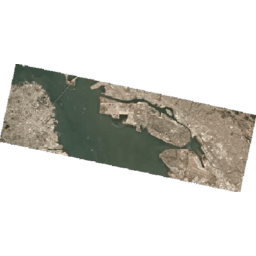

In [7]:
from IPython.display import Image
Image(session.get(info['_links']['thumbnail']).content)

Different Item Types
------------------------------

This is a good place for a bit of a refresher on a couple of key concepts for Planet data.  We have multiple different item types:

|Available Item Types|Description|
|:--- |:--- |
|PSScene3Band|PlanetScope 3 band scenes (red, green, blue) captured by the Dove satellite constellation|
|PSScene4Band|PlanetScope 4 band scenes (red, green, blue, near-infrared) captured by the Dove satellite constellation|
|PSOrthoTile|PlanetScope ortho tiles captured by the Dove satellite constellation|
|REOrthoTile|RapidEye OrthoTiles captured by the RapidEye satellite constellation|
|REScene|Unorthorectified strips captured by the RapidEye satellite constellation|
|SkySatScene|SkySat Scenes captured by the SkySat satellite constellation|
|SkySatCollect|Orthorectified scene composite of a SkySat ccollection|
|Landsat8L1G|Landsat8 Scenes provided by USGS Landsat8 satellite|
|Sentinel2L1C|Copernicus Sentinel-2  Scenes provided by ESA Sentinel-2 satellite|

Most of these represent data from different satellites, but for many of our satellites, the same imagery may be exposed as different itemtypes.  For example, for Planetscope, the same underlying data can be 

The key for this is really geometry. If a representation of the data has a different outline


In [29]:
def get_info(itemtype, sceneid):
    url = '{}/item-types/{}/items/{}'.format(PLANET_API_URL, itemtype, sceneid)
    response = session.get(url)
    response.raise_for_status()
    return response.json()
    

scene = '20191010_183406_0f28'
info_4band = get_info('PSScene4Band', scene)
info_3band = get_info('PSScene3Band', scene)

print('PSScene4Band Geometry')
pprint(info_4band['geometry'])

print('\nPSScene3Band Geometry')
pprint(info_3band['geometry'])

PSScene4Band Geometry
{'coordinates': [[[-122.4463534576134, 37.767959793129485],
                  [-122.43053798540043, 37.827425572894505],
                  [-122.14691934407396, 37.77931677925563],
                  [-122.1498061812017, 37.76873322615015],
                  [-122.14956566784808, 37.768692786563136],
                  [-122.15679131035827, 37.74152641224751],
                  [-122.16615202075121, 37.70722807629772],
                  [-122.44971126634209, 37.75496574134499],
                  [-122.4463534576134, 37.767959793129485]]],
 'type': 'Polygon'}

PSScene3Band Geometry
{'coordinates': [[[-122.4305381111425, 37.82742561824226],
                  [-122.44980510239566, 37.754981875600706],
                  [-122.16592410552973, 37.70718978111152],
                  [-122.1467511467239, 37.77928490053915],
                  [-122.4305381111425, 37.82742561824226]]],
 'type': 'Polygon'}


Notice that the footprints for the same sceneid are slightly different between the two different item types.  The `PSScene4Band` version has a more complex outline (small "stair steps") and is a tiny bit smaller. The differences in area are quite small in this case, but it's not uncommon to see 4-band imagery for a scene be much smaller than 3-band imagery.  This is because our satellites don't actually collect 4-band imagery directly.  The NIR band comes from a different scene taken a second or so later.  Only the pixels that have overlapping NIR data from other scenes can be used. 

This is one of the many reasons we have 

Let's take a quick look at what these metadata fields are.  Note that each ItemType has a different set of metadata.  

https://developers.planet.com/docs/api/psscene3band/

|Property Name|Description|Type|
|:--- |:--- |:--- |
|id|Globally unique item identifier.|string|
|_permissions|The permissions that the authenticated user has to the item.|array|
|item_type|Name of the item type.|string|
|provider|Name of the item provider (e.g. “planetscope”, ”rapideye”).|string|
|satellite_id|Globally unique satellite identifier.|string|
|instrument|Name of the satellite instrument used to collect the image.|string|
|strip_id|The unique identifier of the image stripe that the item came from.|string|
|geometry|Geographic boundary, formatted as a GeoJSON polygon.|json|
|cloud_cover|Average percentage of cloud coverage.|double|
|gsd|Ground sample distance - the distance between pixel centers as measured on the ground in meters.|double|
|pixel_resolution|Pixel resolution of the imagery in meters.|double|
|epsg_code|Ortho tile grid cell that the item is located in (not used if Scene).|integer|
|sun_azimuth|The angle of the sun, as seen by the observer, measured clockwise from the north (0 - 360).|double|
|sun_elevation|The angle of the sun above the horizon (0 - 90).|double|
|view_angle|The satellite's across-track, off-nadir viewing angle. Positive numbers denote east, negative numbers denote west (-25 - +25).|double|
|rows|Number of rows in the image.|integer|
|columns|Number of columns in the image.|integer|
|origin_x|ULX coordinate of the extent of the data. The coordinate references the top left corner of the top left pixel.|double|
|origin_y|ULY coordinate of the extent of the data. The coordinate references the top left corner of the top left pixel.|double|
|quality_category|Planet image quality metric: Standard or Test. To qualify for "standard" image quality an image must meet a variety of quality standards, for example: PAN motion blur less than 1.15 pixels, compression bits per pixel less than 3. If the image does not meet these criteria it is considered "test" quality.|string|
|anomalous_pixels|Percentage of pixels that may have errors. Represented spatially in the UDM.|double|
|usable_data|Percentage of pixels that are usable, subtracting cloud cover and black fill.|double|
|ground_control|Positional accuracy of the item. If the item has uncertain positional accuracy, this value will be false.|boolean|
|acquired|Timestamp that the item was captured.|datetime|
|published|Timestamp that the item was published to the Planet API.|datetime|
|updated|Timestamp that the item record was last updated.|datetime|
